In this first part, we install import all the packages used

In [1]:
#Packages
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Subpackages
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix


#ImportFunctions
from Functions import fetch_data
from Functions import moving_average
from Functions import rsi
from Functions import macd
from Functions import lagged_return
from Functions import bollinger_bands
from Functions import pe_ratio
from Functions import daily_returns






Next, we import some stock data

In [2]:
tickers = ["AAPL", "META"]

start_date = "2013-10-01"
end_date = "2023-10-01"

stock_data = fetch_data(tickers, start_date, end_date)

Now we calculate the technical indicators for each stock

In [3]:
# For each stock's data, compute the technical indicators and add them as new columns to the DataFrame

for ticker, data in stock_data.items():
    # Backup the 'Close' prices
    close_prices = data['Close'].copy()
    
    # 20-day Moving Average
    data['MA20'] = moving_average(data)
    
    # RSI
    data['RSI'] = rsi(data)
    
    # MACD
    data['MACD'], data['Signal_Line'] = macd(data)
    
    # 1, 2, and 3 Day Lagged Returns
    data['Lagged_Return_1'] = lagged_return(data, 1)
    data['Lagged_Return_2'] = lagged_return(data, 2)
    data['Lagged_Return_3'] = lagged_return(data, 3)
    
    # Bollinger Bands
    data['Upper_Bollinger'], data['Lower_Bollinger'] = bollinger_bands(data)
    
    # Restore 'Close' column
    data['Close'] = close_prices

    # Extract the 'Close' column
    close_prices = data['Close']
    
    # Calculate daily returns for all available days
    daily_returns = close_prices.pct_change().dropna()

    



Now that we have all the technical indicators for each stock we make a new dataframe that contains the data for all the stocks. We also do some data cleaning like removing the NANs.

In [4]:
# Dictionary to store the split data for each stock
all_stock_data = {}

for ticker, data in stock_data.items():
    data_clean = data.dropna()  # drop rows with NaN values
    
    # Check if the cleaned data has a minimum number of rows
    if len(data_clean) < 10:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    # Features: using technical indicators and lagged returns
    X = data_clean[['RSI', 'MACD', 'Signal_Line', 'Lagged_Return_1', 'Lagged_Return_2', 'Lagged_Return_3', 'Upper_Bollinger', 'Lower_Bollinger']]

    # Target: Direction of the next day's return (1 for positive, 0 for negative or non-positive)
    y = (data_clean['Close'].pct_change().shift(-1) > 0).astype(int)

    # Splitting the data: 70% train, 15% validation, 15% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)
    
    # Store the data splits in the dictionary
    all_stock_data[ticker] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

# Now, `all_stock_data` contains the data splits for all stocks.


Now we actually make the classifier to predict the stock direction. We use a random forest model to determine this.

In [5]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Combine all stock data with a stock identifier
all_X_train = []
all_y_train = []
all_X_val = []
all_y_val = []

for ticker in all_stock_data:
    # Get data for the current stock
    X_train_temp = all_stock_data[ticker]['X_train'].copy()
    X_train_temp['ticker'] = ticker
    all_X_train.append(X_train_temp)
    
    y_train_temp = all_stock_data[ticker]['y_train']
    all_y_train.append(y_train_temp)
    
    X_val_temp = all_stock_data[ticker]['X_val'].copy()
    X_val_temp['ticker'] = ticker
    all_X_val.append(X_val_temp)
    
    y_val_temp = all_stock_data[ticker]['y_val']
    all_y_val.append(y_val_temp)

# Convert lists to pandas DataFrame
all_X_train = pd.concat(all_X_train, axis=0)
all_y_train = pd.concat(all_y_train, axis=0)
all_X_val = pd.concat(all_X_val, axis=0)
all_y_val = pd.concat(all_y_val, axis=0)

# Convert ticker to a categorical variable
all_X_train['ticker'] = all_X_train['ticker'].astype('category')
all_X_val['ticker'] = all_X_val['ticker'].astype('category')

# One-hot encode the 'ticker' column
all_X_train = pd.get_dummies(all_X_train, columns=['ticker'], drop_first=True)
all_X_val = pd.get_dummies(all_X_val, columns=['ticker'], drop_first=True)

# Continue with the existing code...
# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE for feature selection
selector = RFE(clf, n_features_to_select=3, step=1)
selector = selector.fit(all_X_train, all_y_train)
selected_features = selector.support_
selected_columns = all_X_train.columns[selected_features]

# Train the model with selected features
clf.fit(all_X_train[selected_columns], all_y_train)

# Validate the model
y_val_pred = clf.predict(all_X_val[selected_columns])
accuracy = accuracy_score(all_y_val, y_val_pred)

# Print out the performance
print(f"Performance for the general model:")
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_y_val, y_val_pred))
print("Selected Features:", selected_columns.tolist())


Performance for the general model:
Accuracy: 0.4813
              precision    recall  f1-score   support

           0       0.47      0.42      0.45       371
           1       0.49      0.54      0.51       379

    accuracy                           0.48       750
   macro avg       0.48      0.48      0.48       750
weighted avg       0.48      0.48      0.48       750

Selected Features: ['MACD', 'Lagged_Return_1', 'Lagged_Return_3']


After we have trained the model on the validation set, we will now test on an out of sample test. In other words, we test on new data.

In [6]:
# Dictionary to store test set performances
test_performances = {}

# List to store all accuracy scores
all_accuracies = []

# Combine all test data with a stock identifier
all_X_test = []
all_y_test = []
tickers_test_data = {}  # Store individual test data for each ticker

for ticker in all_stock_data:
    # Get the test data for the current stock
    X_test_temp = all_stock_data[ticker]['X_test'].copy()
    X_test_temp['ticker'] = ticker
    all_X_test.append(X_test_temp)
    
    y_test_temp = all_stock_data[ticker]['y_test']
    all_y_test.append(y_test_temp)
    
    # Store individual test data for each ticker (for later use)
    tickers_test_data[ticker] = {
        'X_test': X_test_temp,
        'y_test': y_test_temp
    }

# Convert lists to pandas DataFrame
all_X_test = pd.concat(all_X_test, axis=0)
all_y_test = pd.concat(all_y_test, axis=0)

# One-hot encode the 'ticker' column
all_X_test = pd.get_dummies(all_X_test, columns=['ticker'], drop_first=True)

# Use only the selected features from RFE for prediction
all_X_test_selected = all_X_test[selected_columns]

# Predict using the trained general model
all_y_test_pred = clf.predict(all_X_test_selected)
# Create a dictionary to store start and end positions of each ticker's data in the combined dataframe
positions = {}
start_pos = 0

for ticker in all_stock_data:
    end_pos = start_pos + len(tickers_test_data[ticker]['X_test'])
    positions[ticker] = (start_pos, end_pos)
    start_pos = end_pos

# Loop through each ticker to extract and display performance
for ticker in all_stock_data:
    y_test_actual = tickers_test_data[ticker]['y_test']
    
    # Use the start and end positions to extract predictions for each ticker
    start, end = positions[ticker]
    y_test_pred_ticker = all_y_test_pred[start:end]
    
    test_accuracy = accuracy_score(y_test_actual, y_test_pred_ticker)
    all_accuracies.append(test_accuracy)

    test_performances[ticker] = {
        'Test Accuracy': test_accuracy,
        'Test Classification Report': classification_report(y_test_actual, y_test_pred_ticker)
    }

    # Print out the test performance for the current stock
    print(f"Test Performance for {ticker}:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test_actual, y_test_pred_ticker))
    print("-------------------------------------------------")

# Calculate and print the average accuracy
average_accuracy = sum(all_accuracies) / len(all_accuracies)
print(f"Average Test Accuracy across all stocks: {average_accuracy:.4f}")

Test Performance for AAPL:
Test Accuracy: 0.5333
              precision    recall  f1-score   support

           0       0.52      0.49      0.50       183
           1       0.54      0.58      0.56       192

    accuracy                           0.53       375
   macro avg       0.53      0.53      0.53       375
weighted avg       0.53      0.53      0.53       375

-------------------------------------------------
Test Performance for META:
Test Accuracy: 0.5440
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       186
           1       0.55      0.57      0.56       189

    accuracy                           0.54       375
   macro avg       0.54      0.54      0.54       375
weighted avg       0.54      0.54      0.54       375

-------------------------------------------------
Average Test Accuracy across all stocks: 0.5387


Now that we have tested the model we want to see if we can improve the accuracy by tuning the hyperparameters. We basically run the same model as before, but this time we tune the model to find the best hyperparameters. We do this to see if we can improve the performance of the model.

In [9]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd
from tqdm import tqdm, tqdm_pandas

# Set up tqdm with pandas
tqdm.pandas(desc="Randomized Search Progress")

# Combine all training and validation data with a stock identifier
all_X_train = []
all_y_train = []
all_X_val = []
all_y_val = []

for ticker in all_stock_data:
    # Get data for the current stock and append the ticker identifier
    X_train_temp = all_stock_data[ticker]['X_train'].copy()
    X_train_temp['ticker'] = ticker
    all_X_train.append(X_train_temp)
    
    y_train_temp = all_stock_data[ticker]['y_train']
    all_y_train.append(y_train_temp)
    
    X_val_temp = all_stock_data[ticker]['X_val'].copy()
    X_val_temp['ticker'] = ticker
    all_X_val.append(X_val_temp)
    
    y_val_temp = all_stock_data[ticker]['y_val']
    all_y_val.append(y_val_temp)

# Convert lists to pandas DataFrame
all_X_train = pd.concat(all_X_train, axis=0)
all_y_train = pd.concat(all_y_train, axis=0)
all_X_val = pd.concat(all_X_val, axis=0)
all_y_val = pd.concat(all_y_val, axis=0)

# One-hot encode the 'ticker' column
all_X_train = pd.get_dummies(all_X_train, columns=['ticker'], drop_first=True)
all_X_val = pd.get_dummies(all_X_val, columns=['ticker'], drop_first=True)
# Create a pipeline with RFE and RandomForestClassifier
pipe = Pipeline([
    ('rfe', RFE(estimator=RandomForestClassifier(random_state=42))),
    ('clf', RandomForestClassifier(random_state=42))
])

# Distributions for hyperparameters
param_dist = {
    'rfe__n_features_to_select': [2, 4, 6, 8], 
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__max_depth': [None, 10, 20, 30, 40],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Instead of the standard fit, use progress_apply to show the progress bar
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1, verbose=10)


random_search.fit(all_X_train, all_y_train)

# Validate the model
y_val_pred = random_search.predict(all_X_val)
accuracy = accuracy_score(all_y_val, y_val_pred)

print(f"Tuned Performance for the general model:")
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_y_val, y_val_pred))
print("Best Hyperparameters:", random_search.best_params_)
print("-------------------------------------------------")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tuned Performance for the general model:
Accuracy: 0.4907
              precision    recall  f1-score   support

           0       0.49      0.52      0.50       371
           1       0.50      0.46      0.48       379

    accuracy                           0.49       750
   macro avg       0.49      0.49      0.49       750
weighted avg       0.49      0.49      0.49       750

Best Hyperparameters: {'rfe__n_features_to_select': 4, 'clf__n_estimators': 50, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10}
-------------------------------------------------


Now that we have tuned the model on the training and validation data, we want to see how well it performs on an out of sample dataset. We use the tuned models on test data:

In [11]:
# Dictionary to store test set performances for the tuned models
tuned_test_performances = {}

# List to store all test accuracy scores for the tuned models
all_tuned_test_accuracies = []

# Combine all test data with a stock identifier and one-hot encode
all_X_test = pd.concat([all_stock_data[ticker]['X_test'].assign(ticker=ticker) for ticker in all_stock_data], axis=0)
all_y_test = pd.concat([all_stock_data[ticker]['y_test'] for ticker in all_stock_data], axis=0)

# One-hot encode the 'ticker' column WITH dropping the first category (to match training data)
all_X_test_encoded = pd.get_dummies(all_X_test, columns=['ticker'], drop_first=True)


# Predict using the tuned general model
all_y_test_pred = random_search.predict(all_X_test_encoded)

# Loop through each ticker to extract and display performance
for ticker in all_stock_data:
    mask = all_X_test['ticker'] == ticker
    y_test_actual = all_y_test[mask]
    y_test_pred_ticker = all_y_test_pred[mask]
    
    test_accuracy = accuracy_score(y_test_actual, y_test_pred_ticker)
    all_tuned_test_accuracies.append(test_accuracy)

    tuned_test_performances[ticker] = {
        'Test Accuracy': test_accuracy,
        'Test Classification Report': classification_report(y_test_actual, y_test_pred_ticker, zero_division=1)
    }

    print(f"Tuned Test Performance for {ticker}:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test_actual, y_test_pred_ticker, zero_division=1))
    print("-------------------------------------------------")

average_tuned_test_accuracy = sum(all_tuned_test_accuracies) / len(all_tuned_test_accuracies)
print(f"\nAverage Tuned Test Accuracy across all stocks: {average_tuned_test_accuracy:.4f}")


Tuned Test Performance for AAPL:
Test Accuracy: 0.5440
              precision    recall  f1-score   support

           0       0.55      0.37      0.44       183
           1       0.54      0.71      0.62       192

    accuracy                           0.54       375
   macro avg       0.55      0.54      0.53       375
weighted avg       0.55      0.54      0.53       375

-------------------------------------------------
Tuned Test Performance for META:
Test Accuracy: 0.5067
              precision    recall  f1-score   support

           0       0.50      0.46      0.48       186
           1       0.51      0.56      0.53       189

    accuracy                           0.51       375
   macro avg       0.51      0.51      0.51       375
weighted avg       0.51      0.51      0.51       375

-------------------------------------------------

Average Tuned Test Accuracy across all stocks: 0.5253


Now that we have done the gridsearch we can evaluate the two models based on their accuracy. We make a table of the results from the validation test and the test data. 

In [12]:
# Non-Tuned Model Results
non_tuned_validation_accuracy = accuracy  # From the non-tuned model validation
non_tuned_test_accuracy = average_accuracy  # From the non-tuned model test

# Tuned Model Results
tuned_validation_accuracy = accuracy  # From the tuned model validation
tuned_test_accuracy = average_tuned_test_accuracy  # From the tuned model test

# Create a DataFrame to compile the results
results = pd.DataFrame({
    'Model': ['Non-Tuned', 'Tuned'],
    'Validation Accuracy': [non_tuned_validation_accuracy, tuned_validation_accuracy],
    'Test Accuracy': [non_tuned_test_accuracy, tuned_test_accuracy]
})

# Display the results
print(results)


       Model  Validation Accuracy  Test Accuracy
0  Non-Tuned             0.490667       0.538667
1      Tuned             0.490667       0.525333


Now we start backtesting the models. We make a list that includes the predicted return and the actual return.

In [27]:
# Initialize the list to store results
stock_results = []

# Loop through each ticker to extract predictions and actual returns
for ticker in all_stock_data:
    # Extract the test data for the current ticker
    mask = all_X_test_encoded.index.isin(tickers_test_data[ticker]['X_test'].index)
    X_test_ticker = all_X_test_encoded[mask]
    y_test_actual = all_y_test[mask]
    
    # Predict using the non-tuned model (clf from previous code)
    non_tuned_predictions = clf.predict(X_test_ticker[selected_columns])
    
    # Predict using the tuned model (random_search from previous code)
    tuned_predictions = random_search.predict(X_test_ticker)
    
    # Calculate the actual daily return for the stock
    # Access the 'Close' column directly from the original stock_data
    daily_returns = stock_data[ticker].loc[tickers_test_data[ticker]['X_test'].index]['Close'].pct_change().shift(-1).dropna()
    
    # Append the results to the stock_results list
    stock_results.append({
        'Ticker': ticker,
        'Non-Tuned Predictions': non_tuned_predictions,
        'Tuned Predictions': tuned_predictions,
        'Actual Daily Returns': daily_returns.values
    })

# Now, the stock_results list contains the predictions from both models and the actual daily returns for each stock.


We perform the backtest and plot the results

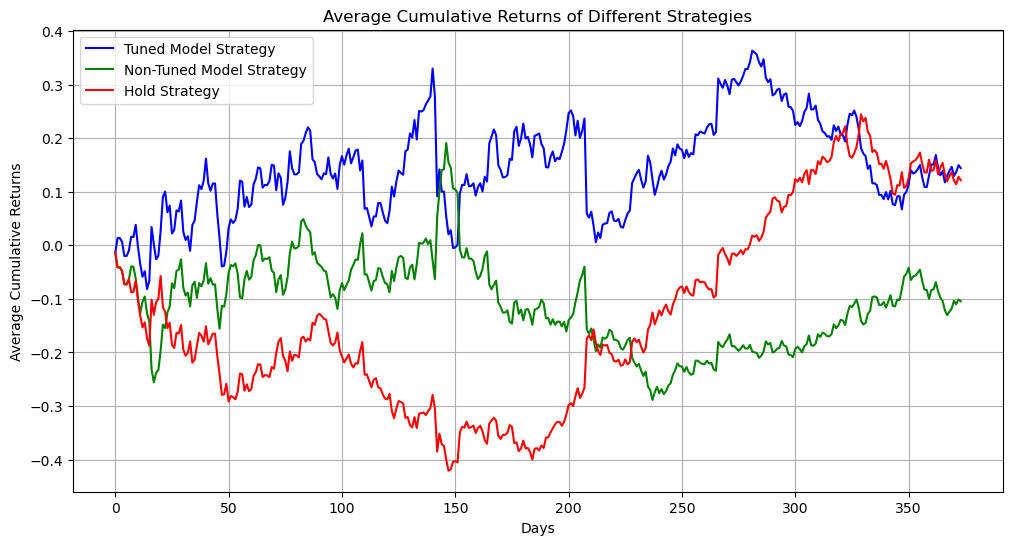

In [31]:
# Initialize lists to store cumulative returns for each strategy
cumulative_returns_tuned = []
cumulative_returns_nontuned = []
cumulative_returns_hold = []

for result in stock_results:
    # Extract only the required number of predictions equal to the length of actual daily returns
    actual_daily_returns = result['Actual Daily Returns']
    tuned_strategy_returns = (result['Tuned Predictions'][:len(actual_daily_returns)] * 2) - 1
    nontuned_strategy_returns = (result['Non-Tuned Predictions'][:len(actual_daily_returns)] * 2) - 1
    
    # Calculate daily strategy returns
    tuned_daily_returns = tuned_strategy_returns * actual_daily_returns
    nontuned_daily_returns = nontuned_strategy_returns * actual_daily_returns
    
    # Calculate the cumulative returns
    cumulative_returns_tuned.append((1 + tuned_daily_returns).cumprod() - 1)
    cumulative_returns_nontuned.append((1 + nontuned_daily_returns).cumprod() - 1)
    cumulative_returns_hold.append((1 + actual_daily_returns).cumprod() - 1)

# Calculate the mean cumulative returns across all stocks for each day
mean_cumulative_returns_tuned = np.nanmean(np.array([np.pad(cr, (0, max(map(len, cumulative_returns_tuned)) - len(cr)), 'edge') for cr in cumulative_returns_tuned]), axis=0)
mean_cumulative_returns_nontuned = np.nanmean(np.array([np.pad(cr, (0, max(map(len, cumulative_returns_nontuned)) - len(cr)), 'edge') for cr in cumulative_returns_nontuned]), axis=0)
mean_cumulative_returns_hold = np.nanmean(np.array([np.pad(cr, (0, max(map(len, cumulative_returns_hold)) - len(cr)), 'edge') for cr in cumulative_returns_hold]), axis=0)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(mean_cumulative_returns_tuned, label="Tuned Model Strategy", color='blue')
plt.plot(mean_cumulative_returns_nontuned, label="Non-Tuned Model Strategy", color='green')
plt.plot(mean_cumulative_returns_hold, label="Hold Strategy", color='red')
plt.title("Average Cumulative Returns of Different Strategies")
plt.xlabel("Days")
plt.ylabel("Average Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


Now we calculate the sharpe ratios from the 3 strategies

In [32]:
# Calculate the daily returns for each strategy
daily_returns_tuned = np.diff(np.array(mean_cumulative_returns_tuned) + 1)
daily_returns_nontuned = np.diff(np.array(mean_cumulative_returns_nontuned) + 1)
daily_returns_hold = np.diff(np.array(mean_cumulative_returns_hold) + 1)

# Calculate Sharpe Ratios
sharpe_ratio_tuned = daily_returns_tuned.mean() / daily_returns_tuned.std()
sharpe_ratio_nontuned = daily_returns_nontuned.mean() / daily_returns_nontuned.std()
sharpe_ratio_hold = daily_returns_hold.mean() / daily_returns_hold.std()

# Print the Sharpe Ratios
print("Sharpe Ratio for Tuned Model Strategy:", sharpe_ratio_tuned)
print("Sharpe Ratio for Non-Tuned Model Strategy:", sharpe_ratio_nontuned)
print("Sharpe Ratio for Hold Strategy:", sharpe_ratio_hold)


Sharpe Ratio for Tuned Model Strategy: 0.015231344705339322
Sharpe Ratio for Non-Tuned Model Strategy: -0.011345058531713803
Sharpe Ratio for Hold Strategy: 0.019215561417713484


Next part of the code will focus more on evaluating the machine learning models. Here we check what kind of parameters the model uses and how well it guesses the direction of the stocks. 

In [33]:
# Access the trained RandomForest model from the RandomizedSearchCV best estimator
rf_model = random_search.best_estimator_.named_steps['clf']

# Get feature importances from the model
feature_importances = rf_model.feature_importances_

# Match the importances with the feature names
features = all_X_train.columns
feature_importance_dict = dict(zip(features, feature_importances))

# Sort the dictionary by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display the sorted feature importances
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance:.4f}")


Feature: MACD, Importance: 0.2746
Feature: Lagged_Return_1, Importance: 0.2452
Feature: RSI, Importance: 0.2437
Feature: Signal_Line, Importance: 0.2365


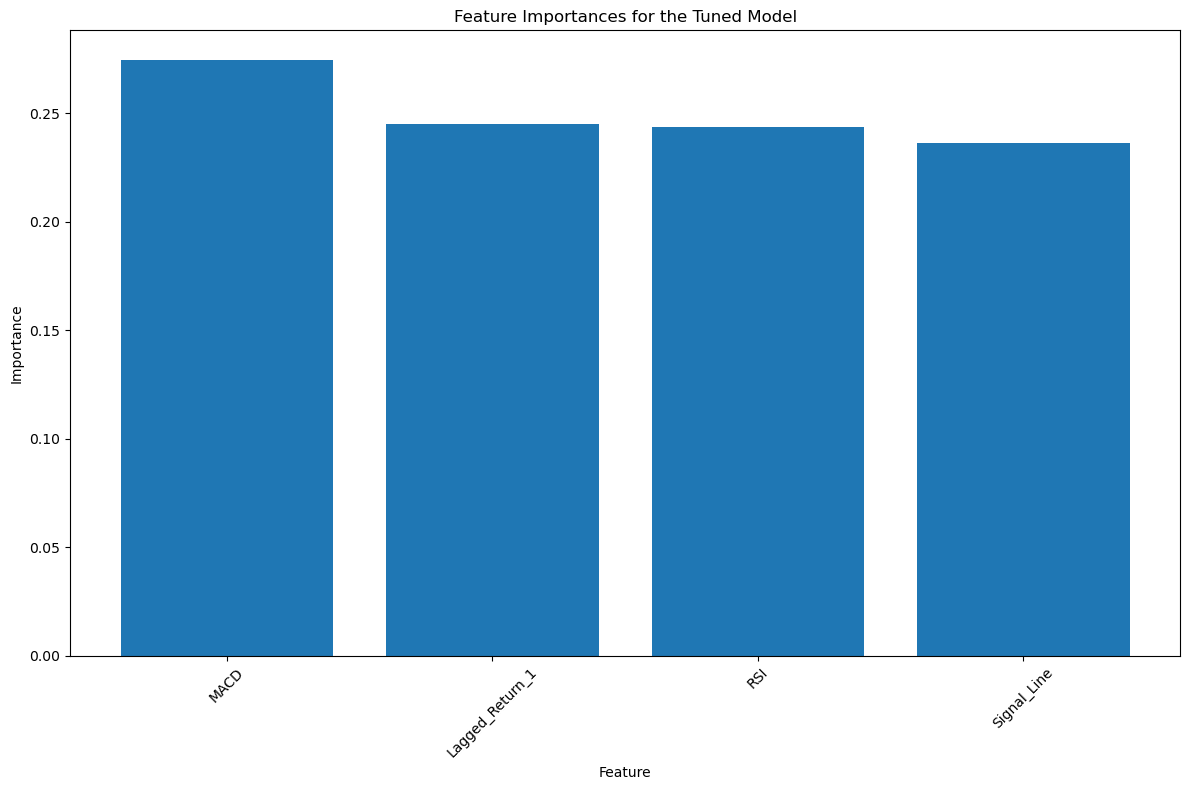

In [36]:
import matplotlib.pyplot as plt

# Extract feature names and their importances
features, importances = zip(*sorted_feature_importance)

# Create the vertical bar plot
plt.figure(figsize=(12, 8))
plt.bar(features, importances, align='center')
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances for the Tuned Model')
plt.tight_layout()  # Adjusts subplot parameters for better layout
plt.show()


In the plot above we have the most important features of the tuned model.

We test how many times the model actually gets the correct answer and how many times it is wrong. We plot a confusion matrix for the two models.

<Figure size 800x600 with 0 Axes>

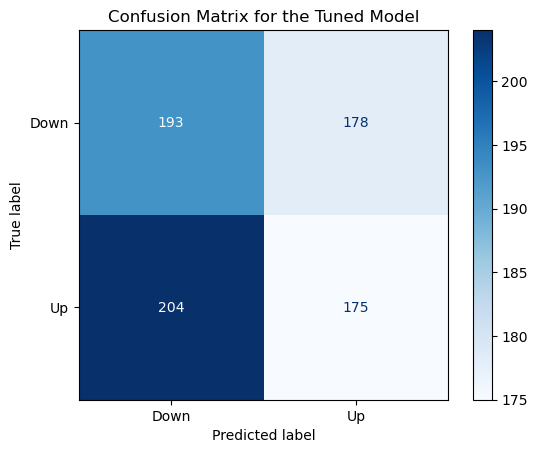

<Figure size 800x600 with 0 Axes>

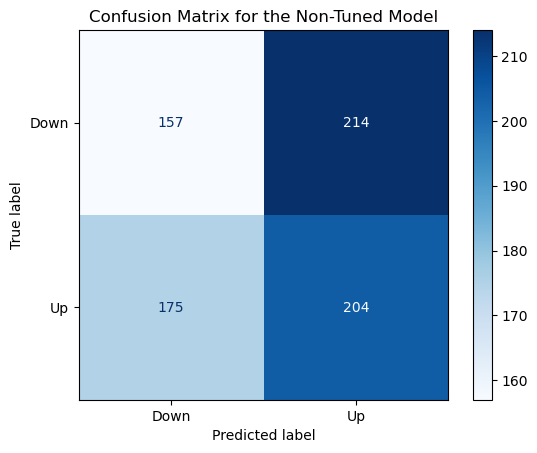

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions from the models
y_pred_tuned = random_search.predict(all_X_val)
y_pred_nontuned = clf.predict(all_X_val[selected_columns])  # Using the non-tuned model and selected columns from earlier

# Confusion matrices
cm_tuned = confusion_matrix(all_y_val, y_pred_tuned)
cm_nontuned = confusion_matrix(all_y_val, y_pred_nontuned)

# Plotting the confusion matrix for the tuned model
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm_tuned, display_labels=['Down', 'Up']).plot(cmap=plt.cm.Blues, values_format='.0f')
plt.title('Confusion Matrix for the Tuned Model')
plt.show()

# Plotting the confusion matrix for the non-tuned model
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm_nontuned, display_labels=['Down', 'Up']).plot(cmap=plt.cm.Blues, values_format='.0f')
plt.title('Confusion Matrix for the Non-Tuned Model')
plt.show()


We make a heatmap for the effects of the hyperparameters on accuracy

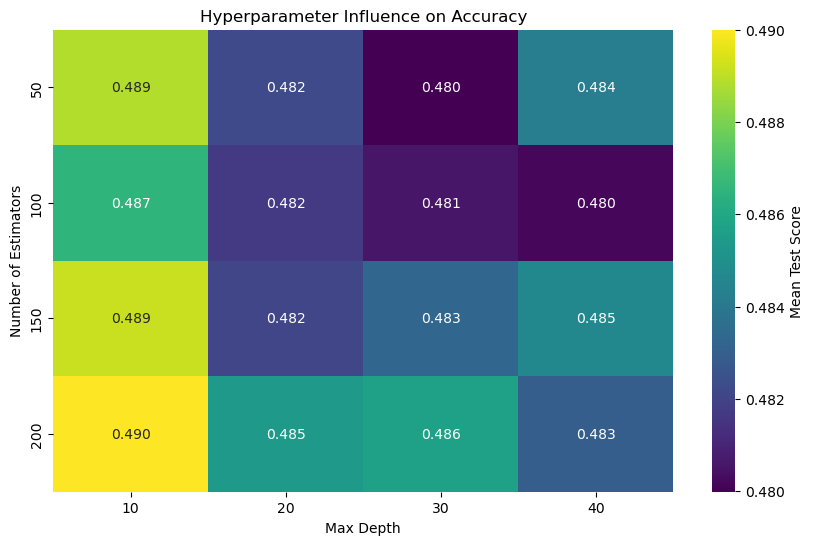

In [38]:
import seaborn as sns

# Extract results from RandomizedSearchCV
results = pd.DataFrame(random_search.cv_results_)

# Pivot the results for heatmap
heatmap_data = results.pivot_table(values='mean_test_score', 
                                   index='param_clf__n_estimators', 
                                   columns='param_clf__max_depth')

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='viridis', cbar_kws={'label': 'Mean Test Score'})
plt.title('Hyperparameter Influence on Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')
plt.show()


ROCAUC comes downunder

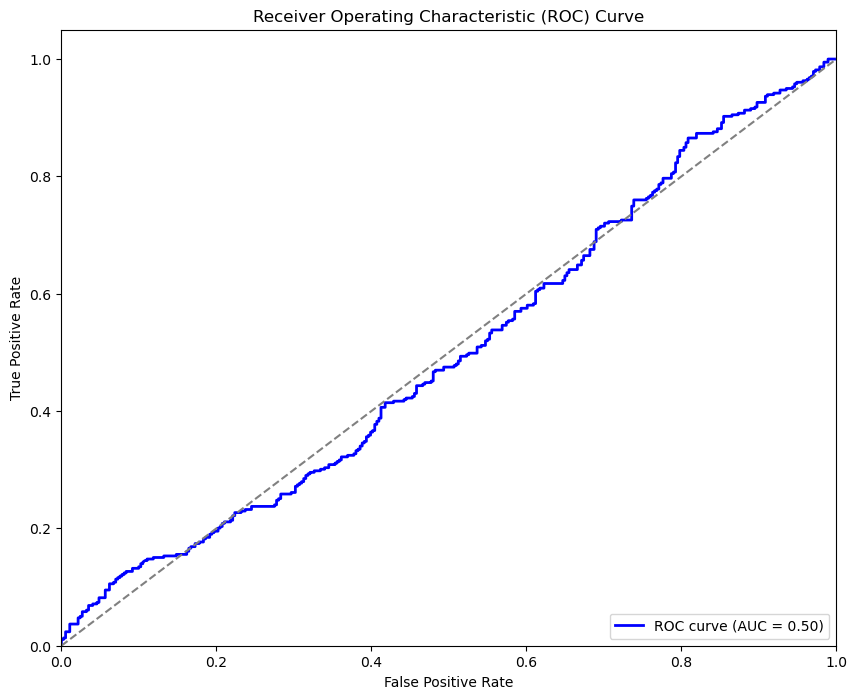

In [39]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class (stock going up)
y_pred_prob_tuned = random_search.predict_proba(all_X_val)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_y_val, y_pred_prob_tuned)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


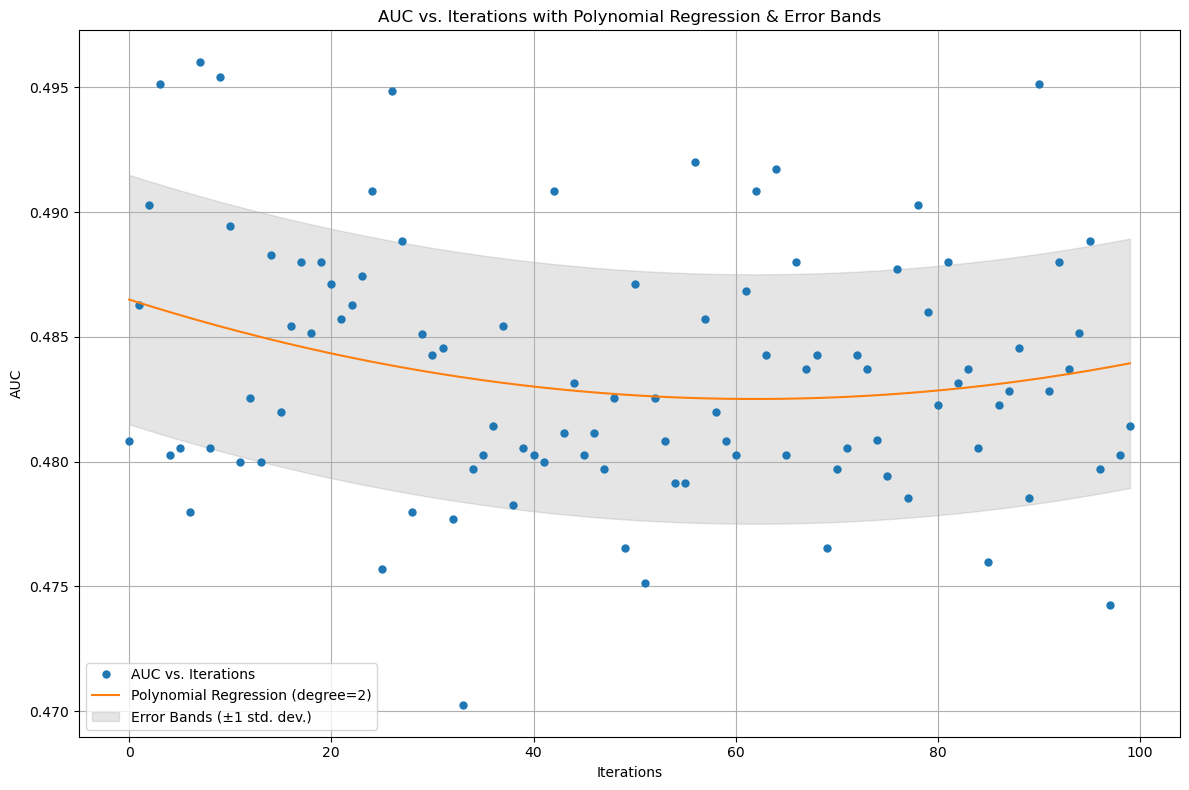

In [40]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import seaborn as sns

# 1. Extract AUC scores and iterations from the RandomizedSearchCV results
results = pd.DataFrame(random_search.cv_results_)
iterations = results.index
mean_test_scores = results["mean_test_score"]

# 2. Fit a polynomial regression to the data
degree = 2
p = Polynomial.fit(iterations, mean_test_scores, degree)
x_new = np.linspace(iterations.min(), iterations.max(), 500)
y_new = p(x_new)

# 3. Compute the standard deviation of the mean test scores to use for error bands
std_dev = mean_test_scores.std()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(iterations, mean_test_scores, 'o', label='AUC vs. Iterations', markersize=5)
plt.plot(x_new, y_new, '-', label=f'Polynomial Regression (degree={degree})')
plt.fill_between(x_new, y_new - std_dev, y_new + std_dev, color='grey', alpha=0.2, label='Error Bands (±1 std. dev.)')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('AUC vs. Iterations with Polynomial Regression & Error Bands')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Ovenstående plot viser hvor meget præcisionen øges når man øger antallet af iterationer i vores random gridsearch. Det hjælper ikke meget mere for præcisionen, så det giver ikke meget mening at øge det. Det ligner at den konvergerer mod det der punkt. 